https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, Conv1D, MaxPooling1D

In [24]:
file = 'LSTM.xlsx'
df = pd.read_excel(file, header=0, engine='openpyxl')

content = df.content
label = df.category

print(len(content), len(label))

16252 16252


In [25]:
categories = np.unique(np.array(label))

label_encoder = LabelEncoder()
label = label_encoder.fit_transform(label)

for i in categories:
    labeled = label_encoder.transform([i])
    print(labeled, '<--', i)

[0] <-- Artificial Intelligence, Machine Learning, Computer Vision, Natural language processing
[1] <-- Information Systems, Search, Information Retrieval, Database Systems, Data Mining, Data Science
[2] <-- Networks and Communications
[3] <-- Security and Privacy
[4] <-- Web, Mobile and Multimedia Technologies


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(content,label, shuffle=True,
                                                    random_state=100, test_size=0.1)

print(Counter(Y_train).keys())
print(Counter(Y_train).values())

print('Train set', len(Y_train))
print('Test set', len(Y_test))

dict_keys([0, 2, 4, 3, 1])
dict_values([2892, 3089, 2809, 2795, 3041])
Train set 14626
Test set 1626


In [27]:
tokenizer = Tokenizer(filters='#')
tokenizer.fit_on_texts(X_train)

In [28]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('size of vocabulary :',total_cnt)
print('words appearing only once (rare words) :', rare_cnt)
print('percentage of rare words in a word set: ', (rare_cnt / total_cnt)*100)
print('percentage of rare word appearance to total appearance frequency: ', (rare_freq / total_freq)*100)
        
# print('단어 집합(vocabulary)의 크기 :',total_cnt)
# print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
# print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
# print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

size of vocabulary : 29556
words appearing only once (rare words) : 8565
percentage of rare words in a word set:  28.978887535525782
percentage of rare word appearance to total appearance frequency:  0.6329127954793843
단어 집합(vocabulary)의 크기 : 29556
등장 빈도가 1번 이하인 희귀 단어의 수: 8565
단어 집합에서 희귀 단어의 비율: 28.978887535525782
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.6329127954793843


In [29]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 20993


In [30]:
tokenizer = Tokenizer( vocab_size, oov_token='OOV', filters='#') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

기사의 최대 길이 : 285
기사의 평균 길이 : 92.52475044441405


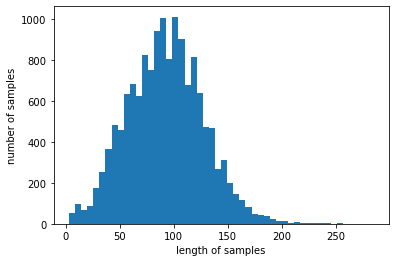

In [31]:
print('기사의 최대 길이 :',max(len(l) for l in X_train))
print('기사의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 100.0


In [33]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [34]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_len))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add((Bidirectional(LSTM(100, recurrent_dropout=0.5))))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 64)           1343552   
_________________________________________________________________
dropout (Dropout)            (None, 300, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           20544     
_________________________________________________________________
dropout_1 (Dropout)          (None, 296, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 74, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               1

In [36]:
optimizer = Adam(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [37]:
history = model.fit(X_train, Y_train, epochs=20, 
                    validation_data=(X_test, Y_test), batch_size=60)

Epoch 1/20
244/244 [==============================] - 210s 820ms/step - loss: 1.5882 - accuracy: 0.2360 - val_loss: 1.4746 - val_accuracy: 0.3567
Epoch 2/20
244/244 [==============================] - 230s 941ms/step - loss: 1.3671 - accuracy: 0.4093 - val_loss: 1.3987 - val_accuracy: 0.3948
Epoch 3/20
244/244 [==============================] - 220s 901ms/step - loss: 1.1960 - accuracy: 0.5061 - val_loss: 1.4004 - val_accuracy: 0.3936
Epoch 4/20
244/244 [==============================] - 210s 861ms/step - loss: 1.0479 - accuracy: 0.5929 - val_loss: 1.4618 - val_accuracy: 0.3905
Epoch 5/20
244/244 [==============================] - 174s 712ms/step - loss: 0.9111 - accuracy: 0.6456 - val_loss: 1.5190 - val_accuracy: 0.3899
Epoch 6/20
244/244 [==============================] - 194s 792ms/step - loss: 0.7846 - accuracy: 0.7038 - val_loss: 1.5954 - val_accuracy: 0.3641
Epoch 7/20
244/244 [==============================] - 184s 755ms/step - loss: 0.6891 - accuracy: 0.7450 - val_loss: 1.6326 -

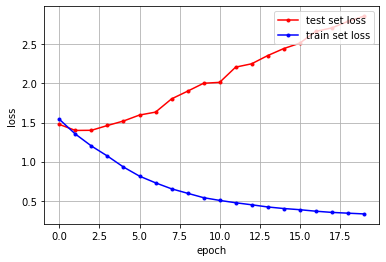

In [39]:
test_loss = history.history['val_loss']
train_loss = history.history['loss']

x_len = np.arange(len(train_loss))
plt.plot(x_len, test_loss, marker='.', c='red', label='test set loss')
plt.plot(x_len, train_loss, marker='.', c='blue', label='train set loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

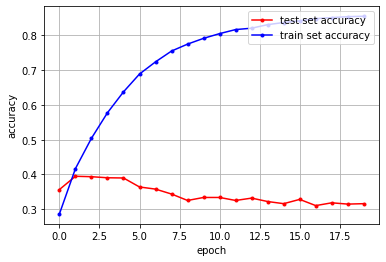

In [40]:
test_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']

x_len = np.arange(len(train_loss))
plt.plot(x_len, test_acc, marker='.', c='red', label='test set accuracy')
plt.plot(x_len, train_acc, marker='.', c='blue', label='train set accuracy')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()